#### (a)
1. Build numeric prediction models that predict Spending based on the other available customer information 
(obviously, not including the Purchase attribute among the inputs!). 
2. Use linear regression, k-NN, regression tree, SVM regreesion and Neural Network and ensembling models. 
3. Briefly discuss your explorations and present the best result (best predictive model) for each of these techniques.
4. Compare the techniques; which of them provides the best predictive performance? 
5. Please make sure you use best practices for predictive modeling. (I.e., do you need to set which hyper-parameter? Normalize?)

In [1]:
# Core packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve, classification_report, confusion_matrix, make_scorer

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor, MLPClassifier

# Ensemble methods
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Data Processing
# Load data
df = pd.read_excel('HW3.xlsx', engine='openpyxl')
# Drop Purchase column
df1 = df.drop('Purchase', axis = 1)

In [23]:
# Linear Regression with L2 Regularization (Tuning Alpha with Grid Search)
x = df1.drop(columns=['sequence_number', 'Spending'])
y = df['Spending']

# Identify numeric and binary columns by name
numeric_cols = ['Freq', 'last_update_days_ago', '1st_update_days_ago']
binary_cols = [col for col in x.columns if col not in numeric_cols]

# Normalization for numeric columns only
scaler = StandardScaler()
x_numeric_scaled = scaler.fit_transform(x[numeric_cols])  # Scale only specified numeric columns

# Combine binary columns (unchanged) with scaled numeric columns
x_processed = np.hstack((x[binary_cols].values, x_numeric_scaled))

# Convert x_processed back to DataFrame for clarity 
all_cols = binary_cols + numeric_cols
x_processed_df = pd.DataFrame(x_processed, columns=all_cols)

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x_processed_df, y, test_size=0.2, random_state=123)

# Setup Linear Regression with L2 Regularization
ridge_model = Ridge()

# Setup Different Alpha Values for Comparison
param_grid = {'alpha':[0.1, 1, 10, 100, 1000]}

# Tune Alpha Values with Grid Search
grid_search = GridSearchCV(ridge_model, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

# Train Model
grid_search.fit(x_train, y_train)

# Print Best Hyperparameter for Alpha & The Corresponding Model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

# Make Prediction with Best Model
best_ridge_model = grid_search.best_estimator_
y_pred = best_ridge_model.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Best parameters: {'alpha': 10}
Best cross-validation score (negative MSE): -15352.634286346347
MSE: 20256.0241868435
R2 Score: 0.45361915053345014


In [24]:
# k-NN (Tuning k numbers of neighbors with Grid Search)
# Note: k-NN also requires normalization, so I use the same training & testing data set with the ones I used for linear regression
x = df1.drop(columns=['sequence_number', 'Spending'])
y = df['Spending']

# Identify numeric and binary columns by name
numeric_cols = ['Freq', 'last_update_days_ago', '1st_update_days_ago']
binary_cols = [col for col in x.columns if col not in numeric_cols]

# Normalization for numeric columns only
scaler = StandardScaler()
x_numeric_scaled = scaler.fit_transform(x[numeric_cols])  # Scale only specified numeric columns

# Combine binary columns (unchanged) with scaled numeric columns
x_processed = np.hstack((x[binary_cols].values, x_numeric_scaled))

# Convert x_processed back to DataFrame for clarity 
all_cols = binary_cols + numeric_cols
x_processed_df = pd.DataFrame(x_processed, columns=all_cols)

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x_processed_df, y, test_size=0.2, random_state=123)

# Build k-NN Model
knn_model = KNeighborsRegressor()

# Build k for Grid Search
param_grid = {'n_neighbors':[2, 5, 10, 15, 20, 50, 100]}

# Perform Grid Search
grid_search = GridSearchCV(knn_model, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

# Train Model
grid_search.fit(x_train, y_train)

# Print Best Hyperparameter & Model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

# Make Prediction with Best Model
best_knn_model = grid_search.best_estimator_
y_pred = best_knn_model.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Best parameters: {'n_neighbors': 10}
Best cross-validation score (negative MSE): -16101.002087816878
MSE: 23171.361364535
R2 Score: 0.3749815862742659


In [25]:
# Regression Tree (Tuning max_depth, min_samples_leaf, min_samples_split with Grid Search)

# Note, we don't need normalization for regression tree, so I'll skip this & just use the training, testing split

# Data
x = df1.drop(columns = ['sequence_number', 'Spending'])
y = df['Spending']

# Training Testing Data Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# Define Regression Tree Model
tree_model = DecisionTreeRegressor(random_state = 123)

# Define Range for the Hyperparameters (max_depth, min_samples_leaf, min_samples_split)
param_grid = {'max_depth':[3, 5, 10, 20, 50], 
              'min_samples_leaf':[1, 2, 5, 10],
              'min_samples_split':[2, 5, 10, 20]}

# Perform Grid Search
grid_search = GridSearchCV(tree_model, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

# Train Model
grid_search.fit(x_train, y_train)

# Print Best Hyperparameter & Best Model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score(negative MSE):", grid_search.best_score_)

# Predict with Best Model
best_tree_model = grid_search.best_estimator_
y_pred = best_tree_model.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Best parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best cross-validation score(negative MSE): -16057.257426473303
MSE: 22187.229773808434
R2 Score: 0.4015273017398555


In [26]:
# SVM Regression (Tune C and epsilon with Grid Search, kernel will be set as RBF)

# Note: SVM requires normalization, so I'll bring this step back

# Data
x = df1.drop(columns=['sequence_number', 'Spending'])
y = df['Spending']

# Identify numeric and binary columns by name
numeric_cols = ['Freq', 'last_update_days_ago', '1st_update_days_ago']
binary_cols = [col for col in x.columns if col not in numeric_cols]

# Normalization for numeric columns only
scaler = StandardScaler()
x_numeric_scaled = scaler.fit_transform(x[numeric_cols])  # Scale only specified numeric columns

# Combine binary columns (unchanged) with scaled numeric columns
x_processed = np.hstack((x[binary_cols].values, x_numeric_scaled))

# Convert x_processed back to DataFrame for clarity 
all_cols = binary_cols + numeric_cols
x_processed_df = pd.DataFrame(x_processed, columns=all_cols)

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x_processed_df, y, test_size=0.2, random_state=123)

# Define SVR Model
svr_model = SVR()

# Define Hyperparameter Range for C & Epsilon
param_grid = {'C':[0.1, 1, 10, 100],
             'epsilon':[0.01, 0.1, 0.5],
             'kernel':['rbf']}

# Perform Grid Search
grid_search = GridSearchCV(svr_model, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

# Train Model
grid_search.fit(x_train, y_train)

# Print Best Hyperparameter & Best Model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

# Make Predictions with Best Model
best_svr_model = grid_search.best_estimator_
y_pred = best_svr_model.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Best parameters: {'C': 100, 'epsilon': 0.5, 'kernel': 'rbf'}
Best cross-validation score (negative MSE): -18008.863640027852
MSE: 23800.307161513843
R2 Score: 0.3580165621583826


In [8]:
# Ensemble Model - Random Forest (Tune n_estimators, max_depth, min_samples_split, min_samples_leaf)
from sklearn.ensemble import RandomForestRegressor

# Data
x = df1.drop(columns = ['sequence_number', 'Spending'])
y = df['Spending']

# Training Testing Data Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# Define Random Forest Model
rf = RandomForestRegressor(random_state = 123)

# Define Hyperparameter Range
param_grid = {'n_estimators':[50, 100, 200],
             'max_depth':[None, 10, 20, 30],
             'min_samples_split':[2,5,10],
             'min_samples_leaf': [1,2,4]}

# Perform Grid Search
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv = 3, scoring = 'neg_mean_squared_error', n_jobs = -1)

# Train Model
grid_search_rf.fit(x_train, y_train)

# Print Best Hyperparameter
print("Best Random Forest Parameters:", grid_search_rf.best_params_)

# Make Prediction with Best Model
y_pred_rf = grid_search_rf.best_estimator_.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R2 Score:", r2_score(y_test, y_pred_rf))

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
MSE: 18922.154054219078
R2 Score: 0.48959862456146575


In [27]:
# Ensemble - Gradient Boosting (Tune n_estimators, learning_rate, max_depth)
from sklearn.ensemble import GradientBoostingRegressor

# Data
x = df1.drop(columns=['sequence_number', 'Spending'])
y = df['Spending']

# Identify numeric and binary columns by name
numeric_cols = ['Freq', 'last_update_days_ago', '1st_update_days_ago']
binary_cols = [col for col in x.columns if col not in numeric_cols]

# Normalization for numeric columns only
scaler = StandardScaler()
x_numeric_scaled = scaler.fit_transform(x[numeric_cols])  # Scale only specified numeric columns

# Combine binary columns (unchanged) with scaled numeric columns
x_processed = np.hstack((x[binary_cols].values, x_numeric_scaled))

# Convert x_processed back to DataFrame for clarity 
all_cols = binary_cols + numeric_cols
x_processed_df = pd.DataFrame(x_processed, columns=all_cols)

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x_processed_df, y, test_size=0.2, random_state=123)

# Define Gradient Boosting Model
gb = GradientBoostingRegressor(random_state = 123)

# Define Hyperparameter Range
param_grid_gb = {'n_estimators':[50, 100, 200],
                'learning_rate':[0.001, 0.01, 0.1],
                'max_depth':[3,5,7]} 

# Perform Grid Search
grid_search_gb = GridSearchCV(estimator = gb, param_grid = param_grid_gb, cv = 3, scoring = 'neg_mean_squared_error', n_jobs = -1)

# Train Model
grid_search_gb.fit(x_train, y_train)

# Print Best Hyperparameter
print("Best Gradient Boosting Parameters:", grid_search_gb.best_params_)

# Make Predictions with best Model
y_pred_gb = grid_search_gb.best_estimator_.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred_gb))
print("R2 Score:", r2_score(y_test, y_pred_gb))

Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
MSE: 19673.42203254566
R2 Score: 0.4693341130073324


In [28]:
# Ensemble - Stacking with Linear Model (Tune n_jobs)
from sklearn.ensemble import StackingRegressor

# Data
x = df1.drop(columns=['sequence_number', 'Spending'])
y = df['Spending']

# Identify numeric and binary columns by name
numeric_cols = ['Freq', 'last_update_days_ago', '1st_update_days_ago']
binary_cols = [col for col in x.columns if col not in numeric_cols]

# Normalization for numeric columns only
scaler = StandardScaler()
x_numeric_scaled = scaler.fit_transform(x[numeric_cols])  # Scale only specified numeric columns

# Combine binary columns (unchanged) with scaled numeric columns
x_processed = np.hstack((x[binary_cols].values, x_numeric_scaled))

# Convert x_processed back to DataFrame for clarity 
all_cols = binary_cols + numeric_cols
x_processed_df = pd.DataFrame(x_processed, columns=all_cols)

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x_processed_df, y, test_size=0.2, random_state=123)

# Define Base Learner
base_learners = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=10, random_state=123)),
    ('gb', GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=123))]

# Define Linear Model as Final Estimator
final_estimator = LinearRegression()

# Define Hyperparameter Range
param_grid_lr = {'n_jobs': [-1, 1, 2]}

# Perform Grid Search
grid_search_lr = GridSearchCV(estimator=final_estimator, param_grid=param_grid_lr, cv=3)

# Train Model
grid_search_lr.fit(x_train, y_train)

# Print Best Hyperparameter
print("Best Linear Regression Parameters:", grid_search_lr.best_params_)

# Define Stacking Model
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=grid_search_lr.best_estimator_)

# Train Stacking Model
stacking_model.fit(x_train, y_train)

# Make Prediction with Stacking Model
y_pred_stack = stacking_model.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred_stack))
print("R2 Score:", r2_score(y_test, y_pred_stack))

Best Linear Regression Parameters: {'n_jobs': -1}
MSE: 19123.35672272122
R2 Score: 0.48417143490583037


In [29]:
# Neural Network (Tune hidden_layer_sizes, activation, learning_rate with Grid Search)
# Currently I am still unable to run with keras package due to AttributeError: 'super' object has no attribute '__sklearn_tags__
# I don't know why I couldn't use Keras & Tensorflow package, they are both successfully installed
# I'll switch to the alternative package sklearn.neural_network.MLPRegressor and MLPClassifier for this Homework
'''
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

# Data
x = df1.drop(columns=['sequence_number', 'Spending'])
y = df['Spending']

# Identify numeric and binary columns by name
numeric_cols = ['Freq', 'last_update_days_ago', '1st_update_days_ago']
binary_cols = [col for col in x.columns if col not in numeric_cols]

# Normalization for numeric columns only
scaler = StandardScaler()
x_numeric_scaled = scaler.fit_transform(x[numeric_cols])  # Scale only specified numeric columns

# Combine binary columns (unchanged) with scaled numeric columns
x_processed = np.hstack((x[binary_cols].values, x_numeric_scaled))

# Convert x_processed back to DataFrame for clarity 
all_cols = binary_cols + numeric_cols
x_processed_df = pd.DataFrame(x_processed, columns=all_cols)

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x_processed_df, y, test_size=0.2, random_state=123)

# Define a function to build neural network model
def create_model(hidden_layer_sizes=(100,), activation='relu', learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units=hidden_layer_sizes[0], activation=activation, input_dim=x_train.shape[1]))
    for units in hidden_layer_sizes[1:]:
        model.add(Dense(units=units, activation=activation))
    
    model.add(Dense(1))  
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

# Define KerasRegressor for Grid Search
model = KerasRegressor(model = create_model, epochs = 50, batch_size = 32, verbose = 0)

# Define Hyperparameter Range
param_grid = {'hidden_layer_sizes':[(50, ), (100, ), (50, 50), (100, 100)], 
             'activation': ['relu', 'tanh'],
             'learning_rate':[0.001, 0.01, 0.1]}

# Perform Grid Search
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, scoring = 'neg_mean_squared_error')

# Train Model
grid_search.fit(x_train, y_train)

# Print Best Hyperparameter & Best Model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

# Make Prediction with Best Model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))
'''

'\nfrom keras.models import Sequential\nfrom keras.layers import Dense\nfrom keras.optimizers import Adam\nfrom scikeras.wrappers import KerasRegressor\n\n# Data\nx = df1.drop(columns=[\'sequence_number\', \'Spending\'])\ny = df[\'Spending\']\n\n# Identify numeric and binary columns by name\nnumeric_cols = [\'Freq\', \'last_update_days_ago\', \'1st_update_days_ago\']\nbinary_cols = [col for col in x.columns if col not in numeric_cols]\n\n# Normalization for numeric columns only\nscaler = StandardScaler()\nx_numeric_scaled = scaler.fit_transform(x[numeric_cols])  # Scale only specified numeric columns\n\n# Combine binary columns (unchanged) with scaled numeric columns\nx_processed = np.hstack((x[binary_cols].values, x_numeric_scaled))\n\n# Convert x_processed back to DataFrame for clarity (optional, but recommended for inspection)\nall_cols = binary_cols + numeric_cols\nx_processed_df = pd.DataFrame(x_processed, columns=all_cols)\n\n# Training Testing Split\nx_train, x_test, y_train, y_

In [30]:
# Neural Network w sklearn (Tune hidden_layer_sizes, activation, alpha with Grid Search)
from sklearn.neural_network import MLPRegressor

# Data
x = df1.drop(columns=['sequence_number', 'Spending'])
y = df['Spending']

# Identify numeric and binary columns by name
numeric_cols = ['Freq', 'last_update_days_ago', '1st_update_days_ago']
binary_cols = [col for col in x.columns if col not in numeric_cols]

# Normalization for numeric columns only
scaler = StandardScaler()
x_numeric_scaled = scaler.fit_transform(x[numeric_cols])  # Scale only specified numeric columns

# Combine binary columns (unchanged) with scaled numeric columns
x_processed = np.hstack((x[binary_cols].values, x_numeric_scaled))

# Convert x_processed back to DataFrame for clarity 
all_cols = binary_cols + numeric_cols
x_processed_df = pd.DataFrame(x_processed, columns=all_cols)

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x_processed_df, y, test_size=0.2, random_state=123)

# Define MLPRegressor
model = MLPRegressor(max_iter=2000, solver='adam', early_stopping=True, tol=1e-3, validation_fraction=0.1, random_state=123)

# Define Hyperparameter Range
param_grid = {'hidden_layer_sizes':[(50,), (100,)],
             'activation':['relu', 'tanh'],
             'alpha':[0.001, 0.01]}

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring = 'neg_mean_squared_error', n_jobs = -1)

# Train Model
grid_search.fit(x_train, y_train)

# Print Best Hyperparameter & Best Model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score(negative MSE):", grid_search.best_score_)

# Make Prediction with Best Model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,)}
Best cross-validation score(negative MSE): -17462.107030990348
MSE: 21341.381576506417
R2 Score: 0.4243429960882953


Compare results:
- Linear Model
    - Best parameters: {'alpha': 10}
    - Best cross-validation score (negative MSE): -15352.634286346356
    - MSE: 20256.024186843497
    - R2 Score: 0.45361915053345014
- k-NN
    - Best parameters: {'n_neighbors': 10}
    - Best cross-validation score (negative MSE): -16101.002087816878
    - MSE: 23171.361364535
    - R2 Score: 0.3749815862742659
- Regression Tree
    - Best parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
    - Best cross-validation score(negative MSE): -16057.257426473303
    - MSE: 22187.229773808434
    - R2 Score: 0.4015273017398555
- SVM
    - Best parameters: {'C': 100, 'epsilon': 0.5, 'kernel': 'rbf'}
    - Best cross-validation score (negative MSE): -18008.863640027852
    - MSE: 23800.307161513843
    - R2 Score: 0.3580165621583826
- Ensemble: Random Forest
    - Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
    - MSE: 18922.154054219078
    - R2 Score: 0.48959862456146575
- Ensemble: Gradient Boosting
    - Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
    - MSE: 19673.42203254566
    - R2 Score: 0.4693341130073324
- Ensemble: Stacking
    - Best Linear Regression Parameters: {'n_jobs': -1}
    - MSE: 19123.35672272122
    - R2 Score: 0.48417143490583037
- Neural Netowrk
    - Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,)}
    - Best cross-validation score(negative MSE): -17462.107030990348
    - MSE: 21341.381576506417
    - R2 Score: 0.4243429960882953
 
For my test, Ensemble: Random Forest provides the best performance

#### (b)
As a variation on this exercise, create a separate “restricted” dataset (i.e., a subset of the original dataset), which includes only purchase records (i.e., where Purchase = 1). Build numeric prediction models to predict Spending for this restricted dataset. All the same requirements as for task (a) apply.

In [32]:
# Data Processing
df2 = df[df['Purchase'] == 1]
df2 = df2.drop('Purchase', axis = 1)

In [33]:
# Linear Regression with L2 Regularization (Tuning Alpha with Grid Search)
x = df2.drop(columns = ['sequence_number', 'Spending'])
y = df2['Spending']

# Identify numeric and binary columns by name
numeric_cols = ['Freq', 'last_update_days_ago', '1st_update_days_ago']
binary_cols = [col for col in x.columns if col not in numeric_cols]

# Normalization for numeric columns only
scaler = StandardScaler()
x_numeric_scaled = scaler.fit_transform(x[numeric_cols])  # Scale only specified numeric columns

# Combine binary columns (unchanged) with scaled numeric columns
x_processed = np.hstack((x[binary_cols].values, x_numeric_scaled))

# Convert x_processed back to DataFrame for clarity
all_cols = binary_cols + numeric_cols
x_processed_df = pd.DataFrame(x_processed, columns=all_cols)

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x_processed_df, y, test_size=0.2, random_state=123)

# Setup Linear Regression with L2 Regularization
ridge_model = Ridge()

# Setup Different Alpha Values for Comparison
param_grid = {'alpha':[0.1, 1, 10, 100, 1000]}

# Tune Alpha Values with Grid Search
grid_search = GridSearchCV(ridge_model, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

# Train Model
grid_search.fit(x_train, y_train)

# Print Best Hyperparameter for Alpha & The Corresponding Model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

# Make Prediction with Best Model
best_ridge_model = grid_search.best_estimator_
y_pred = best_ridge_model.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Best parameters: {'alpha': 10}
Best cross-validation score (negative MSE): -26573.57746632917
MSE: 28534.061074275436
R2 Score: 0.4483485401927687


In [34]:
# k-NN (Tuning k numbers of neighbors with Grid Search)
# Note: k-NN also requires normalization
x = df2.drop(columns = ['sequence_number', 'Spending'])
y = df2['Spending']

# Identify numeric and binary columns by name
numeric_cols = ['Freq', 'last_update_days_ago', '1st_update_days_ago']
binary_cols = [col for col in x.columns if col not in numeric_cols]

# Normalization for numeric columns only
scaler = StandardScaler()
x_numeric_scaled = scaler.fit_transform(x[numeric_cols])  # Scale only specified numeric columns

# Combine binary columns (unchanged) with scaled numeric columns
x_processed = np.hstack((x[binary_cols].values, x_numeric_scaled))

# Convert x_processed back to DataFrame for clarity
all_cols = binary_cols + numeric_cols
x_processed_df = pd.DataFrame(x_processed, columns=all_cols)

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x_processed_df, y, test_size=0.2, random_state=123)

# Build k-NN Model
knn_model = KNeighborsRegressor()

# Build k for Grid Search
param_grid = {'n_neighbors':[2, 5, 10, 15, 20, 50, 100]}

# Perform Grid Search
grid_search = GridSearchCV(knn_model, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

# Train Model
grid_search.fit(x_train, y_train)

# Print Best Hyperparameter & Model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

# Make Prediction with Best Model
best_knn_model = grid_search.best_estimator_
y_pred = best_knn_model.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Best parameters: {'n_neighbors': 5}
Best cross-validation score (negative MSE): -27977.50898514
MSE: 34005.88764404
R2 Score: 0.34256124594239135


In [35]:
# Regression Tree (Tuning max_depth, min_samples_leaf, min_samples_split with Grid Search)

# Note, we don't need normalization for regression tree, so I'll skip this & just use the training, testing split
x = df2.drop(columns = ['sequence_number', 'Spending'])
y = df2['Spending']

# Training Testing Data Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# Define Regression Tree Model
tree_model = DecisionTreeRegressor(random_state = 123)

# Define Range for the Hyperparameters (max_depth, min_samples_leaf, min_samples_split)
param_grid = {'max_depth':[3, 5, 10, 20, 50], 
              'min_samples_leaf':[1, 2, 5, 10],
              'min_samples_split':[2, 5, 10, 20]}

# Perform Grid Search
grid_search = GridSearchCV(tree_model, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

# Train Model
grid_search.fit(x_train, y_train)

# Print Best Hyperparameter & Best Model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score(negative MSE):", grid_search.best_score_)

# Predict with Best Model
best_tree_model = grid_search.best_estimator_
y_pred = best_tree_model.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Best parameters: {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best cross-validation score(negative MSE): -29876.995744456664
MSE: 40919.94608552041
R2 Score: 0.20889115872603703


In [36]:
# SVM Regression (Tune C and epsilon with Grid Search, kernel will be set as RBF)

# Note: SVM requires normalization, so I'll bring this step back
x = df2.drop(columns = ['sequence_number', 'Spending'])
y = df2['Spending']

# Identify numeric and binary columns by name
numeric_cols = ['Freq', 'last_update_days_ago', '1st_update_days_ago']
binary_cols = [col for col in x.columns if col not in numeric_cols]

# Normalization for numeric columns only
scaler = StandardScaler()
x_numeric_scaled = scaler.fit_transform(x[numeric_cols])  # Scale only specified numeric columns

# Combine binary columns (unchanged) with scaled numeric columns
x_processed = np.hstack((x[binary_cols].values, x_numeric_scaled))

# Convert x_processed back to DataFrame for clarity
all_cols = binary_cols + numeric_cols
x_processed_df = pd.DataFrame(x_processed, columns=all_cols)

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x_processed_df, y, test_size=0.2, random_state=123)

# Define SVR Model
svr_model = SVR()

# Define Hyperparameter Range for C & Epsilon
param_grid = {'C':[0.1, 1, 10, 100],
             'epsilon':[0.01, 0.1, 0.5],
             'kernel':['rbf']}

# Perform Grid Search
grid_search = GridSearchCV(svr_model, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

# Train Model
grid_search.fit(x_train, y_train)

# Print Best Hyperparameter & Best Model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

# Make Predictions with Best Model
best_svr_model = grid_search.best_estimator_
y_pred = best_svr_model.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Best parameters: {'C': 100, 'epsilon': 0.01, 'kernel': 'rbf'}
Best cross-validation score (negative MSE): -30911.11960321597
MSE: 33094.33722217206
R2 Score: 0.36018432874166006


In [37]:
# Ensemble Model - Random Forest (Tune n_estimators, max_depth, min_samples_split, min_samples_leaf)
from sklearn.ensemble import RandomForestRegressor
x = df2.drop(columns = ['sequence_number', 'Spending'])
y = df2['Spending']

# Training Testing Data Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)


# Define Random Forest Model
rf = RandomForestRegressor(random_state = 123)

# Define Hyperparameter Range
param_grid = {'n_estimators':[50, 100, 200],
             'max_depth':[None, 10, 20, 30],
             'min_samples_split':[2,5,10],
             'min_samples_leaf': [1,2,4]}

# Perform Grid Search
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv = 3, scoring = 'neg_mean_squared_error', n_jobs = -1)

# Train Model
grid_search_rf.fit(x_train, y_train)

# Print Best Hyperparameter
print("Best Random Forest Parameters:", grid_search_rf.best_params_)

# Make Prediction with Best Model
y_pred_rf = grid_search_rf.best_estimator_.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R2 Score:", r2_score(y_test, y_pred_rf))

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
MSE: 27427.765099400367
R2 Score: 0.4697366555377974


In [18]:
# Ensemble - Gradient Boosting (Tune n_estimators, learning_rate, max_depth)
from sklearn.ensemble import GradientBoostingRegressor

# Define Gradient Boosting Model
gb = GradientBoostingRegressor(random_state = 123)

# Define Hyperparameter Range
param_grid_gb = {'n_estimators':[50, 100, 200],
                'learning_rate':[0.001, 0.01, 0.1],
                'max_depth':[3,5,7]} 

# Perform Grid Search
grid_search_gb = GridSearchCV(estimator = gb, param_grid = param_grid_gb, cv = 3, scoring = 'neg_mean_squared_error', n_jobs = -1)

# Train Model
grid_search_gb.fit(x_train, y_train)

# Print Best Hyperparameter
print("Best Gradient Boosting Parameters:", grid_search_gb.best_params_)

# Make Predictions with best Model
y_pred_gb = grid_search_gb.best_estimator_.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred_gb))
print("R2 Score:", r2_score(y_test, y_pred_gb))

Best Gradient Boosting Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
MSE: 27562.224592476
R2 Score: 0.46713713857990513


In [19]:
# Ensemble - Stacking with Linear Model (Tune n_jobs)
from sklearn.ensemble import StackingRegressor
# Define Base Learner
base_learners = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=10, random_state=123)),
    ('gb', GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=123))]

# Define Linear Model as Final Estimator
final_estimator = LinearRegression()

# Define Hyperparameter Range
param_grid_lr = {'n_jobs': [-1, 1, 2]}

# Perform Grid Search
grid_search_lr = GridSearchCV(estimator=final_estimator, param_grid=param_grid_lr, cv=3)

# Train Model
grid_search_lr.fit(x_train, y_train)

# Print Best Hyperparameter
print("Best Linear Regression Parameters:", grid_search_lr.best_params_)

# Define Stacking Model
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=grid_search_lr.best_estimator_)

# Train Stacking Model
stacking_model.fit(x_train, y_train)

# Make Prediction with Stacking Model
y_pred_stack = stacking_model.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred_stack))
print("R2 Score:", r2_score(y_test, y_pred_stack))

Best Linear Regression Parameters: {'n_jobs': -1}
MSE: 27335.166924757985
R2 Score: 0.4715268640217558


In [38]:
# Neural Network w sklearn (Tune hidden_layer_sizes, activation, alpha with Grid Search)
from sklearn.neural_network import MLPRegressor
x = df2.drop(columns = ['sequence_number', 'Spending'])
y = df2['Spending']

# Identify numeric and binary columns by name
numeric_cols = ['Freq', 'last_update_days_ago', '1st_update_days_ago']
binary_cols = [col for col in x.columns if col not in numeric_cols]

# Normalization for numeric columns only
scaler = StandardScaler()
x_numeric_scaled = scaler.fit_transform(x[numeric_cols])  # Scale only specified numeric columns

# Combine binary columns (unchanged) with scaled numeric columns
x_processed = np.hstack((x[binary_cols].values, x_numeric_scaled))

# Convert x_processed back to DataFrame for clarity
all_cols = binary_cols + numeric_cols
x_processed_df = pd.DataFrame(x_processed, columns=all_cols)

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x_processed_df, y, test_size=0.2, random_state=123)

# Define MLPRegressor
model = MLPRegressor(max_iter=2000, solver='adam', early_stopping=True, tol=1e-3, validation_fraction=0.1, random_state=123)

# Define Hyperparameter Range
param_grid = {'hidden_layer_sizes':[(50,), (100,)],
             'activation':['relu', 'tanh'],
             'alpha':[0.001, 0.01]}

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring = 'neg_mean_squared_error', n_jobs = -1)

# Train Model
grid_search.fit(x_train, y_train)

# Print Best Hyperparameter & Best Model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score(negative MSE):", grid_search.best_score_)

# Make Prediction with Best Model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,)}
Best cross-validation score(negative MSE): -31889.48944804684
MSE: 41034.08311383023
R2 Score: 0.20668453772942263


Compare results:
- Linear Model
    - Best parameters: {'alpha': 10}
    - Best cross-validation score (negative MSE): -26573.57746632917
    - MSE: 28534.061074275436
    - R2 Score: 0.4483485401927687
- k-NN
    - Best parameters: {'n_neighbors': 5}
    - Best cross-validation score (negative MSE): -27977.50898514
    - MSE: 34005.88764404
    - R2 Score: 0.34256124594239135
- Regression Tree
    - Best parameters: {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}
    - Best cross-validation score(negative MSE): -29876.995744456664
    - MSE: 40919.94608552041
    - R2 Score: 0.20889115872603703
- SVM
    - Best parameters: {'C': 100, 'epsilon': 0.01, 'kernel': 'rbf'}
    - Best cross-validation score (negative MSE): -30911.11960321597
    - MSE: 33094.33722217206
    - R2 Score: 0.36018432874166006
- Ensemble: Random Forest
    - Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
    - MSE: 27427.765099400367
    - R2 Score: 0.4697366555377974
- Ensemble: Gradient Boosting
    - Best Gradient Boosting Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
    - MSE: 27562.224592476
    - R2 Score: 0.46713713857990513
- Ensemble: Stacking
    - Best Linear Regression Parameters: {'n_jobs': -1}
    - MSE: 27335.166924757985
    - R2 Score: 0.4715268640217558
- Neural Netowrk
    - Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,)}
    - Best cross-validation score(negative MSE): -31889.48944804684
    - MSE: 41034.08311383023
    - R2 Score: 0.20668453772942263

For my test, Ensemble: Stacking with linear regression model provides the best performance

#### (c)
For each predictive modeling technique, discuss the predictive performance differences between the models built for task (a) vs. task (b): which models exhibit better predictive performance? Why do you think that is?

Overall, for almost every predictive modeling technique, the models in task (a) perform better. The main reason is that task (a) uses a larger and more diverse dataset, allowing the models to learn patterns more effectively with sufficient data. In task (a), we have 1,000 records of non-purchasers, so the variance in spending amounts is much smaller compared to the dataset used in task (b). This increased the difficulty of predicting spending among only purchasers.

# Spam Email Prediction

## Data Source

The dataset used for this project is the Spambase dataset, available at the UCI Machine Learning Repository: http://archive.ics.uci.edu/ml/datasets/Spambase.

* The file spambase.data contains the actual dataset.

* The files spambase.names and spambase.DOCUMENTATION provide detailed attribute and dataset descriptions.

The dataset includes 4,601 email records, each represented by 58 attributes:

* Attributes 1–57 capture various content-based features such as the frequency of specific words, punctuation symbols, and capitalization patterns.

* Attribute 58 is the binary class label, indicating whether the message is spam (1) or not (0).

## Goal

The objective of this project is twofold:

1. Build baseline classifiers to detect spam emails based on their content characteristics.

    * I'll explore a range of modeling techniques including classic algorithms, ensemble methods, and neural networks.
    
    * The primary metric for comparison is overall predictive accuracy, without considering any cost asymmetry.

2. Optimize for cost-sensitive classification by identifying models that minimize the average misclassification cost, incorporating cost implications associated with false positives and false negatives.

## 📌 Project Tasks Overview

1. **Model Exploration**  
   - Implement multiple classification algorithms: Logistic Regression, k-NN, Decision Tree, SVM, Neural Network, and Ensemble methods.  
   - Perform hyperparameter tuning using cross-validation techniques (e.g., GridSearchCV).

2. **Data Preprocessing**  
   - Normalize input features using `StandardScaler` to ensure fair treatment across models sensitive to scale.

3. **Cost-Sensitive Learning**  
   - Incorporate a **10:1 misclassification cost ratio**, where false positives (non-spam predicted as spam) are penalized 10× more than false negatives.

4. **Model Evaluation with Nested Cross-Validation**  
   - Apply **Nested CV** to separate hyperparameter tuning from performance evaluation.  
   - Evaluate using the following metrics:
     - Accuracy
     - Precision, Recall, F1-score
     - Area Under the ROC Curve (AUC)
     - **Average Misclassification Cost**
     - Confusion Matrix

5. **Visualization of Model Performance**  
   - Generate visual indicators:
     - ROC Curves
     - Lift Charts
     - Confusion Matrix Heatmaps

6. **Documentation Deliverable**  
   - Produce a write-up summarizing modeling strategy, results, and interpretations.

7. **Final Reporting & Conclusions**  
   - Compare model performance across standard vs. cost-sensitive setups.  
   - Highlight the best-performing models for each scenario:
     - Discuss optimal hyperparameters
     - Provide metric comparisons  
   - Conclude with key takeaways and practical insights.

In [7]:
# Core packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve, classification_report, confusion_matrix, make_scorer

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor, MLPClassifier

# Ensemble methods
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
# Load Data
headers = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 
          'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 
          'word_freq_people','word_freq_report','word_freq_addresses','word_freq_free','word_freq_business','word_freq_email',
          'word_freq_you','word_freq_credit','word_freq_your','word_freq_font','word_freq_000','word_freq_money','word_freq_hp',
          'word_freq_hpl','word_freq_george','word_freq_650','word_freq_lab','word_freq_labs','word_freq_telnet','word_freq_857',
          'word_freq_data','word_freq_415','word_freq_85','word_freq_technology','word_freq_1999','word_freq_parts','word_freq_pm',
          'word_freq_direct','word_freq_cs','word_freq_meeting','word_freq_original','word_freq_project','word_freq_re',
          'word_freq_edu','word_freq_table','word_freq_conference','char_freq_;','char_freq_(','char_freq_[','char_freq_!',
          'char_freq_$','char_freq_#','capital_run_length_average' ,'capital_run_length_longest', 'capital_run_length_total', 'spam']
spam_df = pd.read_csv('spambase.data', header=None, names=headers)
spam_df.head(5).style

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.000000,0.640000,0.640000,0.000000,0.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.640000,0.000000,0.000000,0.000000,0.320000,0.000000,1.290000,1.930000,0.000000,0.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.778000,0.000000,0.000000,3.756000,61,278,1
1,0.210000,0.280000,0.500000,0.000000,0.140000,0.280000,0.210000,0.070000,0.000000,0.940000,0.210000,0.790000,0.650000,0.210000,0.140000,0.140000,0.070000,0.280000,3.470000,0.000000,1.590000,0.000000,0.430000,0.430000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.132000,0.000000,0.372000,0.180000,0.048000,5.114000,101,1028,1
2,0.060000,0.000000,0.710000,0.000000,1.230000,0.190000,0.190000,0.120000,0.640000,0.250000,0.380000,0.450000,0.120000,0.000000,1.750000,0.060000,0.060000,1.030000,1.360000,0.320000,0.510000,0.000000,1.160000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000,0.000000,0.120000,0.000000,0.060000,0.060000,0.000000,0.000000,0.010000,0.143000,0.000000,0.276000,0.184000,0.010000,9.821000,485,2259,1
3,0.000000,0.000000,0.000000,0.000000,0.630000,0.000000,0.310000,0.630000,0.310000,0.630000,0.310000,0.310000,0.310000,0.000000,0.000000,0.310000,0.000000,0.000000,3.180000,0.000000,0.310000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.137000,0.000000,0.137000,0.000000,0.000000,3.537000,40,191,1
4,0.000000,0.000000,0.000000,0.000000,0.630000,0.000000,0.310000,0.630000,0.310000,0.630000,0.310000,0.310000,0.310000,0.000000,0.000000,0.310000,0.000000,0.000000,3.180000,0.000000,0.310000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.135000,0.000000,0.135000,0.000000,0.000000,3.537000,40,191,1


In [44]:
spam_df.describe().style

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,0.059824,0.541702,0.093930,0.058626,0.049205,0.248848,0.142586,0.184745,1.662100,0.085577,0.809761,0.121202,0.101645,0.094269,0.549504,0.265384,0.767305,0.124845,0.098915,0.102852,0.064753,0.047048,0.097229,0.047835,0.105412,0.097477,0.136953,0.013201,0.078629,0.064834,0.043667,0.132339,0.046099,0.079196,0.301224,0.179824,0.005444,0.031869,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,0.201545,0.861698,0.301036,0.335184,0.258843,0.825792,0.444055,0.531122,1.775481,0.509767,1.200810,1.025756,0.350286,0.442636,1.671349,0.886955,3.367292,0.538576,0.593327,0.456682,0.403393,0.328559,0.555907,0.329445,0.532260,0.402623,0.423451,0.220651,0.434672,0.349916,0.361205,0.766819,0.223812,0.621976,1.011687,0.911119,0.076274,0.285735,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.310000,0.000000,0.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

#### (i) Finding the best possible model for overall predictive accuracy
For this classification problem, I will first test out the following model without actually diving into hyperparameter tuning first:
- Logistic Regression
- Decision Tree (Classification Tree)
- k-NN (k-Nearest Neighbors)
- Random Forest (Classifier)
- Gradient Boosting (Classifier)
- Ensemble Model - Stacking with Decision Trees
- SVC (Support Vector Classifier)
- Neural Network (Classifier)

My goal is to identify, with the default settings, which models show a relatively higher performance. 
After that, I will compare the better performing models & explore how the performance varies across different hyperparameter settings.

In [24]:
# Define x & y
x = spam_df.drop(columns=['spam'])
y = spam_df['spam']

# Define Model with Default Hyperparameters
models = [
    ('Logistic Regression', LogisticRegression(max_iter=500)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('SVC', SVC(probability=True)),
    ('MLPClassifier', MLPClassifier(max_iter=500, early_stopping=True))
]

# Define Decision Trees for the stacking ensemble model
estimators = [('dt1', DecisionTreeClassifier(max_depth=3)), ('dt2', DecisionTreeClassifier(max_depth=5))]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
models.append(('Stacking (Decision Trees)', stacking_model))

# Compare Models with Default Hyperparemter Settings
results = []
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

for name, model in models:
    if name in ['Logistic Regression', 'KNN', 'SVC', 'MLPClassifier']:
        scores = cross_val_score(model, x_scaled, y, cv=5, scoring='accuracy')
    else:
        scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')
    avg_score = np.mean(scores)
    results.append((name, avg_score))
    print(f"{name} (Default) ➜ CV Accuracy: {avg_score:.4f}")

# Rank the top three performing models
results.sort(key=lambda x: x[1], reverse=True)
top_models = results[:3]
print("\nTop 3 Models (Default):", top_models)

Logistic Regression (Default) ➜ CV Accuracy: 0.9113
Decision Tree (Default) ➜ CV Accuracy: 0.8792
KNN (Default) ➜ CV Accuracy: 0.8837
Random Forest (Default) ➜ CV Accuracy: 0.9291
Gradient Boosting (Default) ➜ CV Accuracy: 0.9302
SVC (Default) ➜ CV Accuracy: 0.9231
MLPClassifier (Default) ➜ CV Accuracy: 0.9237
Stacking (Decision Trees) (Default) ➜ CV Accuracy: 0.8874

Top 3 Models (Default): [('Gradient Boosting', 0.9302294292593117), ('Random Forest', 0.9291427087759052), ('MLPClassifier', 0.9237091063588727)]


The top 3 models with better performance are Gradient Boosting, Random Forest and MLPClassifier. 
As a result, I'll perform GridSearch to identify the best performing hyperparameters and compare the performance of these three models.
Note, since it's super time consuming to do it all within the same chunk of code or a nested CV structure, I'll do this separatedly.

In [31]:
# Gradient Boosting (Tuning n_estimators, learning_rate, max_depth)

# Define x & y
x = spam_df.drop(columns=['spam'])
y = spam_df['spam'].values

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# Define Model
model = GradientBoostingClassifier(random_state=123)

# Define Hyperparameter Range
param_grid = {
    'n_estimators': [50, 200, 400],       
    'learning_rate': [0.001, 0.01, 0.1],    
    'max_depth': [3, 20, 50]}

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy',n_jobs=-1)

# Train Model
grid_search.fit(x_train, y_train)

# Print Results
print("Gradient Boosting - Grid Search Results:")
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Evaluate on Test Set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Gradient Boosting - Grid Search Results:
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400}
Best cross-validation accuracy: 0.9315113144390775
Test set accuracy: 0.9565689467969598
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       558
           1       0.96      0.93      0.94       363

    accuracy                           0.96       921
   macro avg       0.96      0.95      0.95       921
weighted avg       0.96      0.96      0.96       921



In [32]:
# Random Forest (Tune n_estimators, max_depth, min_samples_split)
# Define x & y
x = spam_df.drop(columns=['spam'])
y = spam_df['spam'].values

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# Define Model
model = RandomForestClassifier(random_state=123)

# Define Hyperparemeter Range
param_grid = {'n_estimators': [50, 200, 400],
    'max_depth': [3, 20, 50],           
    'min_samples_split': [2, 10, 50]}

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Train Model
grid_search.fit(x_train, y_train)

# Print Results
print("Random Forest - Grid Search Results:")
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Evaluate on Test Set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Random Forest - Grid Search Results:
Best parameters: {'max_depth': 50, 'min_samples_split': 10, 'n_estimators': 400}
Best cross-validation accuracy: 0.9285221097004901
Test set accuracy: 0.9554831704668838
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       558
           1       0.97      0.92      0.94       363

    accuracy                           0.96       921
   macro avg       0.96      0.95      0.95       921
weighted avg       0.96      0.96      0.96       921



In [33]:
# MLP Classifier

# Normalization for MLPClassifier
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=123)

# Define MLPClassifier
model = MLPClassifier(max_iter=2000, activation = 'relu', solver='adam', early_stopping=True, validation_fraction=0.1, random_state=123)
# Note, I set the activation function as relu only because I tried tanh and others but relu is the only one that returns a result

# Define Hyperparameter Range
param_grid = {
    'hidden_layer_sizes': [(50,), (100,)], 
    'learning_rate_init': [0.0001, 0.001, 0.01]}

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Train Model
grid_search.fit(x_train, y_train)

# Print Results
print("MLPClassifier - Grid Search Results:")
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Evaluate on Test Set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

MLPClassifier - Grid Search Results:
Best parameters: {'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01}
Best cross-validation accuracy: 0.9285334106227783
Test set accuracy: 0.9533116178067318
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       563
           1       0.93      0.95      0.94       358

    accuracy                           0.95       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921



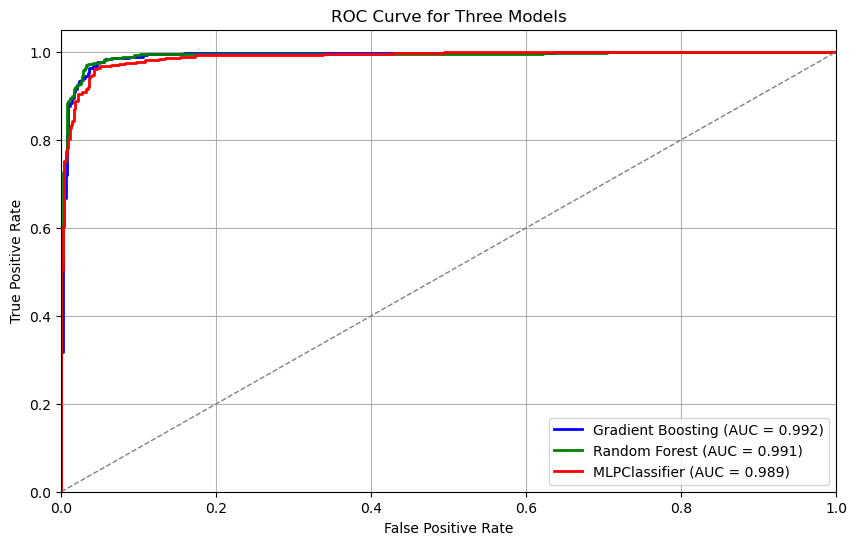

AUC Scores:
Gradient Boosting: 0.992
Random Forest: 0.991
MLPClassifier: 0.989


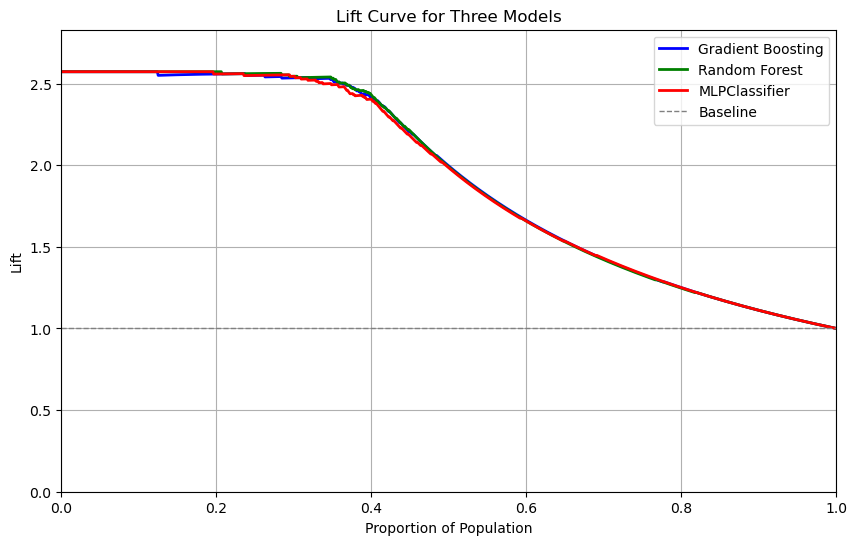

In [40]:
# Plot ROC & Lift Curve for the three best performing models
# Data
x = spam_df.drop(columns=['spam'])
y = spam_df['spam'].values

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# Normalization for MLP
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(x_scaled, y, test_size=0.2, random_state=123)

# Define the three models with the corresponding best performing hyperparameters
models = {'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=400, random_state=123),
    'Random Forest': RandomForestClassifier(max_depth=50, min_samples_split=10, n_estimators=400, random_state=123),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, activation='relu', solver='adam', early_stopping=True, validation_fraction=0.1, random_state=123)}

# Store ROC & Lift Data
roc_data = {}
lift_data = {}

# Train Model
for name, model in models.items():
    # MLPClassifier requires normalized data
    if name == 'MLPClassifier':
        model.fit(x_train_scaled, y_train_scaled)
        y_pred_proba = model.predict_proba(x_test_scaled)[:, 1]
        y_test_local = y_test_scaled
    else:
        model.fit(x_train, y_train)
        y_pred_proba = model.predict_proba(x_test)[:, 1]
        y_test_local = y_test
    
    # Get ROC Curve Data
    fpr, tpr, _ = roc_curve(y_test_local, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

    # Get Lift Curve Data
    sorted_indices = np.argsort(y_pred_proba)[::-1]
    sorted_y_test = y_test_local[sorted_indices]  # 現在 y_test_local 是 NumPy 陣列，索引正常
    cum_positive = np.cumsum(sorted_y_test)
    cum_population = np.arange(1, len(y_test_local) + 1)
    lift = cum_positive / cum_positive[-1]  # 正例比例
    baseline = cum_population / len(y_test_local)  # 基準線
    lift_score = lift / baseline
    lift_data[name] = (cum_population / len(y_test_local), lift_score)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
colors = {'Gradient Boosting': 'blue', 'Random Forest': 'green', 'MLPClassifier': 'red'}
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, color=colors[name], lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Three Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print AUC Scores
print("AUC Scores:")
for name, (_, _, roc_auc) in roc_data.items():
    print(f"{name}: {roc_auc:.3f}")

# Plot Lift Curve
plt.figure(figsize=(10, 6))
for name, (x_axis, lift_score) in lift_data.items():
    plt.plot(x_axis, lift_score, color=colors[name], lw=2, label=name)
plt.plot([0, 1], [1, 1], color='gray', lw=1, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, max([max(lift_data[name][1]) for name in lift_data]) * 1.1])
plt.xlabel('Proportion of Population')
plt.ylabel('Lift')
plt.title('Lift Curve for Three Models')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

Comparing the three models across accuracy, precision(class 1), recall (class 1), f1-score (class 1), and AUC score:
- Accuracy: Gradient Boosting > Random Forest > MLPClassifier
- Precision: Random Forest >  Gradient Boosting > MLPClassifier
- Recall: MLPClassifier > Gradient Boosting > Random Forest
- F1-score: Same
- AUC: Gradient Boosting > Random Forest > MLPClassifier

Even though these three models all performed pretty well according to the ROC curve and lift curve, overall Gradient Boosting is a relatively better performing model, with accuracy at 0.9565689467969598, precision_1 at 0.96, recall_1 at 0.93, f1-score at 0.94, and AUC score at 0.992.



#### (ii) Finding the best cost-sensitive classification model for average misclassification cost

For part ii, I'll follow the similar approach. 
I will first test out the following model without actually diving into hyperparameter tuning first:
- Logistic Regression
- Decision Tree (Classification Tree)
- k-NN (k-Nearest Neighbors)
- Random Forest (Classifier)
- Gradient Boosting (Classifier)
- Ensemble Model - Stacking with Decision Trees
- SVC (Support Vector Classifier)
- Neural Network (Classifier)

I will compare the default settings of these models based on their average misclassification cost. 
After that, I will compare the better performing models & explore how the performance varies across different hyperparameter settings.

Note in this context settings, it is clear that false positive (we classify the email as spam when it's not spam) is more severe. 
This misclassification might result in someone missing out on an important email. 
Therefore, the associated cost for false positive cases will be calculated as 10, and 1 for false negative cases. 

In [42]:
# Define x & y
x = spam_df.drop(columns=['spam'])
y = spam_df['spam'].values 

# Define Model with Default Hyperparameters
models = [
    ('Logistic Regression', LogisticRegression(max_iter=500)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('SVC', SVC(probability=True)),
    ('MLPClassifier', MLPClassifier(max_iter=500, early_stopping=True))
]

# Define Decision Trees for the stacking ensemble model
estimators = [('dt1', DecisionTreeClassifier(max_depth=3)), ('dt2', DecisionTreeClassifier(max_depth=5))]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
models.append(('Stacking (Decision Trees)', stacking_model))

# Compare Models with Default Hyperparameter Settings based on Misclassification Cost
results = []
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Define Misclassification Cost
def calculate_misclassification_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    cost = (10 * fp) + (1 * fn)  # FP = 10, FN = 1
    total_cost = cost / len(y_true) 
    return total_cost

for name, model in models:
    if name in ['Logistic Regression', 'KNN', 'SVC', 'MLPClassifier']:
        y_pred = cross_val_predict(model, x_scaled, y, cv=5)
    else:
        y_pred = cross_val_predict(model, x, y, cv=5)
    
    # Calculate Average Misclassification Cost
    avg_cost = calculate_misclassification_cost(y, y_pred)
    results.append((name, avg_cost))
    print(f"{name} (Default) ➜ Avg Misclassification Cost: {avg_cost:.4f}")

# Rank the top three performing models 
results.sort(key=lambda x: x[1])  
top_models = results[:3]
print("\nTop 3 Models (Default) based on Misclassification Cost:", top_models)

Logistic Regression (Default) ➜ Avg Misclassification Cost: 0.4603
Decision Tree (Default) ➜ Avg Misclassification Cost: 0.6477
KNN (Default) ➜ Avg Misclassification Cost: 0.6190
Random Forest (Default) ➜ Avg Misclassification Cost: 0.3873
Gradient Boosting (Default) ➜ Avg Misclassification Cost: 0.3632
SVC (Default) ➜ Avg Misclassification Cost: 0.3586
MLPClassifier (Default) ➜ Avg Misclassification Cost: 0.4247
Stacking (Decision Trees) (Default) ➜ Avg Misclassification Cost: 0.4523

Top 3 Models (Default) based on Misclassification Cost: [('SVC', 0.3586176918061291), ('Gradient Boosting', 0.36318191697457075), ('Random Forest', 0.38730710715061945)]


The top 3 models with the lowest average misclassification cost are SVC, Gradient Boosting and Random Forest. 
As a result, I'll perform GridSearch to identify the best performing hyperparameters and compare the performance of these three models. Note, since it's super time consuming to do it all within the same chunk of code or a nested CV structure, I'll do this separatedly.

In [46]:
# SVC (Tune C and kernel)
# Define x & y
x = spam_df.drop(columns=['spam'])
y = spam_df['spam'].values

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# Normalization for SVC
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Define cost_scorer to identify the best model
cost_scorer = make_scorer(calculate_misclassification_cost, greater_is_better=False)

# Define SVC
model = SVC(probability=True, random_state=123)

# Define hyperparameter range
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 
              'kernel': ['rbf', 'linear']}

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,cv=3,scoring=cost_scorer,n_jobs=-1)

# Train Model
grid_search.fit(x_train_scaled, y_train)

# Print Results
print("SVC - Grid Search Results:")
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation avg misclassification cost:", -grid_search.best_score_)  # 負號轉回正值

# Evaluate on Test Set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test_scaled)
test_cost = calculate_misclassification_cost(y_test, y_pred)
print("Test set avg misclassification cost:", test_cost)

SVC - Grid Search Results:
Best parameters: {'C': 0.1, 'kernel': 'rbf'}
Best cross-validation avg misclassification cost: 0.301907462730223
Test set avg misclassification cost: 0.2736156351791531


In [47]:
# Gradient Boosting
# Define x & y
x = spam_df.drop(columns=['spam'])
y = spam_df['spam'].values

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# Define cost_scorer to identify the best model
cost_scorer = make_scorer(calculate_misclassification_cost, greater_is_better=False)

# Define Gradient Boosting
model = GradientBoostingClassifier(random_state=123)

# Define hyperparameter range
param_grid = {
    'n_estimators': [50, 200, 400],      
    'learning_rate': [0.001, 0.01, 0.1],        
    'max_depth': [3, 5, 10, 20]}

# Perform Grid Search
grid_search = GridSearchCV(estimator=model,param_grid=param_grid,cv=3,scoring=cost_scorer,n_jobs=-1)

# Train Model
grid_search.fit(x_train, y_train)

# Print Results
print("Gradient Boosting - Grid Search Results:")
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation avg misclassification cost:", -grid_search.best_score_)

# Evaluate on Test Set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
test_cost = calculate_misclassification_cost(y_test, y_pred)
print("Test set avg misclassification cost:", test_cost)

Gradient Boosting - Grid Search Results:
Best parameters: {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 400}
Best cross-validation avg misclassification cost: 0.24156297516500455
Test set avg misclassification cost: 0.12160694896851248


In [48]:
# Random Forest
# Define x & y
x = spam_df.drop(columns=['spam'])
y = spam_df['spam'].values

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# Define cost_scorer to identify the best model
cost_scorer = make_scorer(calculate_misclassification_cost, greater_is_better=False)

# Define Random Forest
model = RandomForestClassifier(random_state=123)

# Define hyperparameter range
param_grid = {'n_estimators': [50, 200, 400],
              'max_depth': [10, 20, 50],
              'min_samples_split': [2, 5, 10]}

# Perform Grid Search
grid_search = GridSearchCV(estimator=model,param_grid=param_grid,cv=3,scoring=cost_scorer,n_jobs=-1)

# Train Model
grid_search.fit(x_train, y_train)

# Print Results
print("Random Forest - Grid Search Results:")
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation avg misclassification cost:", -grid_search.best_score_)

# Evaluate on Test Set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
test_cost = calculate_misclassification_cost(y_test, y_pred)
print("Test set avg misclassification cost:", test_cost)

Random Forest - Grid Search Results:
Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 400}
Best cross-validation avg misclassification cost: 0.22717468522499693
Test set avg misclassification cost: 0.16829533116178066


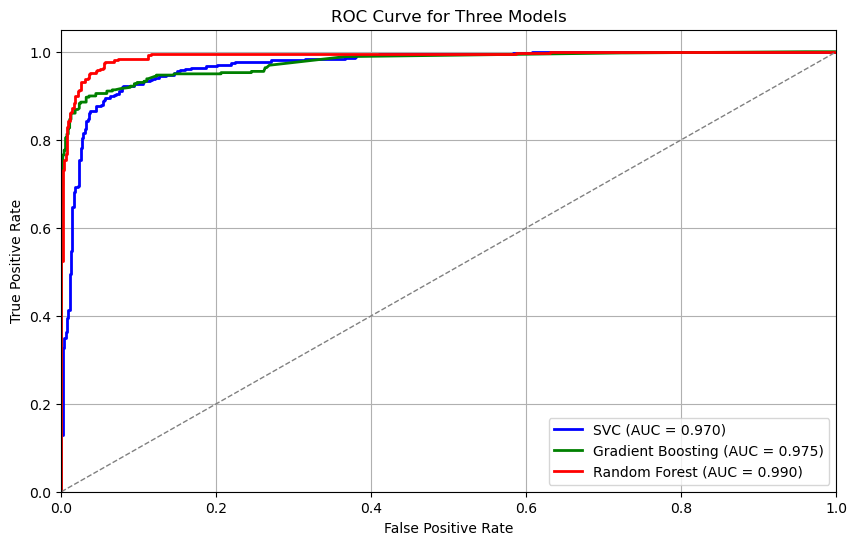

AUC Scores:
SVC: 0.970
Gradient Boosting: 0.975
Random Forest: 0.990


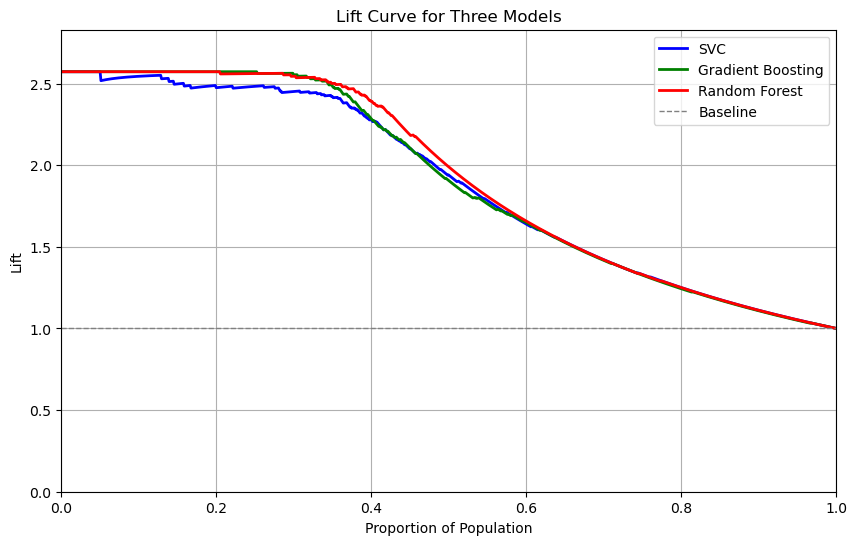

In [49]:
# Plot ROC & Lift Curve for the three best performing models
# Data
x = spam_df.drop(columns=['spam'])
y = spam_df['spam'].values

# Training Testing Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# Normalization for SVC
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(x_scaled, y, test_size=0.2, random_state=123)

# Define the three models with the corresponding best performing hyperparameters
models = {'SVC': SVC(C = 0.1, kernel = 'rbf', probability = True, random_state = 123),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate = 0.001, max_depth = 5, n_estimators = 400, random_state = 123),
    'Random Forest': RandomForestClassifier(max_depth = 10, min_samples_split = 2, n_estimators = 400, random_state = 123)}

# Store ROC & Lift Data
roc_data = {}
lift_data = {}

# Train Model
for name, model in models.items():
    # MLPClassifier requires normalized data
    if name == 'SVC':
        model.fit(x_train_scaled, y_train_scaled)
        y_pred_proba = model.predict_proba(x_test_scaled)[:, 1]
        y_test_local = y_test_scaled
    else:
        model.fit(x_train, y_train)
        y_pred_proba = model.predict_proba(x_test)[:, 1]
        y_test_local = y_test
    
    # Get ROC Curve Data
    fpr, tpr, _ = roc_curve(y_test_local, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

    # Get Lift Curve Data
    sorted_indices = np.argsort(y_pred_proba)[::-1]
    sorted_y_test = y_test_local[sorted_indices]  
    cum_positive = np.cumsum(sorted_y_test)
    cum_population = np.arange(1, len(y_test_local) + 1)
    lift = cum_positive / cum_positive[-1]  
    baseline = cum_population / len(y_test_local)  
    lift_score = lift / baseline
    lift_data[name] = (cum_population / len(y_test_local), lift_score)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
colors = {'SVC': 'blue', 'Gradient Boosting': 'green', 'Random Forest': 'red'}
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, color=colors[name], lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Three Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print AUC Scores
print("AUC Scores:")
for name, (_, _, roc_auc) in roc_data.items():
    print(f"{name}: {roc_auc:.3f}")

# Plot Lift Curve
plt.figure(figsize=(10, 6))
for name, (x_axis, lift_score) in lift_data.items():
    plt.plot(x_axis, lift_score, color=colors[name], lw=2, label=name)
plt.plot([0, 1], [1, 1], color='gray', lw=1, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, max([max(lift_data[name][1]) for name in lift_data]) * 1.1])
plt.xlabel('Proportion of Population')
plt.ylabel('Lift')
plt.title('Lift Curve for Three Models')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

Comparing the three models, Gradient Boosting returns the lowest average misclassification cost with the test data at 0.12160694896851248.